### Imports

In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%autoreload 2

In [8]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [9]:
connection = Connection()
# Get client
client = connection.get_client()

In [10]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [11]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [12]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
W06 Record count after target preprocessing: 100
W06 Record count after preprocessing: 100
W08 original record count: 69
W08 Record count before target preprocessing: 66
W08 Record count after target preprocessing: 66
W08 Record count after preprocessing: 66
W10 original record count: 222
W10 Record count before target preprocessing: 221
W10 Record count after target preprocessing: 221
W10 Record count after preprocessing: 221
W11 original record count: 154
W11 Record count before target preprocessing: 119
W11 Record count after target preprocessing: 119
W11 Record count after preprocessing: 119
W15 original record count: 86
W15 Record count before target preprocessing: 86
W15 Record count after target preprocessing: 86
W15 Record count after preprocessing: 86
W18 original record count: 89
W18 Record count before target preprocessing: 86
W18 Record count after target preproc

755

In [13]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [14]:
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=525, Validation=72, Test=158


In [15]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [16]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.7285


In [17]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.6729365887237233,
   'mae': 16.429389625801864,
   'rmse': 18.634981682167542,
   'mape (%)': 16.30150671761364,
   'mpe (%)': 0.03448426371950047},
  'qw': {'r2': 0.05586633243299455,
   'mae': 0.9953796599582009,
   'rmse': 1.2554371130574384,
   'mape (%)': 542.3406754847412,
   'mpe (%)': 497.1792346644648},
  'qg': {'r2': 0.560900138249631,
   'mae': 2580.7806493352155,
   'rmse': 3397.8620313950432,
   'mape (%)': 1998.3209226159947,
   'mpe (%)': 1976.0773488883747},
  'wgr': {'r2': -0.9190817419213131,
   'mae': 7.683370283964724e-05,
   'rmse': 0.00011172499987827314,
   'mape (%)': 601.2858205177137,
   'mpe (%)': 560.4416254291974},
  'gor': {'r2': -0.652033323328747,
   'mae': 15.638513244380935,
   'rmse': 37.193996570721126,
   'mape (%)': 1524.147796283113,
   'mpe (%)': 1513.5959690864245}},
 'W08': {'qo': {'r2': -0.8148658946872434,
   'mae': 11.692713476308061,
   'rmse': 14.499517450860669,
   'mape (%)': 50.42802512723096,
   'mpe (%)': -4.32

In [18]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.7037181321236992,
   'mae': 15.337842089459896,
   'rmse': 17.736402101442813,
   'mape (%)': 12.266230466144098,
   'mpe (%)': -7.964548487377825},
  'qw': {'r2': -1.7672621053190087,
   'mae': 1.7176263867866115,
   'rmse': 2.1493313268842,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.8158823672794173,
   'mae': 1420.3079607361828,
   'rmse': 2200.2487430183255,
   'mape (%)': 1310.7754896262984,
   'mpe (%)': 1301.1774608535734},
  'wgr': {'r2': -1.878891863770459,
   'mae': 0.00011054892377470422,
   'rmse': 0.00013684101984501424,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -0.05042312760896239,
   'mae': 17.618014454601973,
   'rmse': 29.65825416509273,
   'mape (%)': 1250.9626391737083,
   'mpe (%)': 1249.3877813485442}},
 'W08': {'qo': {'r2': 0.40519684415514734,
   'mae': 7.0231230946857055,
   'rmse': 8.300761033627241,
   'mape (%)': 37.21011106894733,
   'mpe (%)': 4.145717273412839},
  'qw': {'r2': 0.559271293086160

In [19]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9726685491405559,
   'mae': 4.922587284526167,
   'rmse': 5.386967213092686,
   'mape (%)': 3.829536200705154,
   'mpe (%)': 3.5410108934811744},
  'qw': {'r2': -1.5420558213554214,
   'mae': 1.6602542746790518,
   'rmse': 2.0600168001964594,
   'mape (%)': 98.445713501407,
   'mpe (%)': -98.445713501407},
  'qg': {'r2': 0.8474218938765019,
   'mae': 1032.8473394224147,
   'rmse': 2002.9504255890292,
   'mape (%)': 1423.416976151633,
   'mpe (%)': 1423.416976151633},
  'wgr': {'r2': -1.6969155784819567,
   'mae': 0.00010727436244702765,
   'rmse': 0.00013244552892514684,
   'mape (%)': 98.3880248504935,
   'mpe (%)': -98.3880248504935},
  'gor': {'r2': -0.10848349651204048,
   'mae': 10.434898412455762,
   'rmse': 30.466885530044742,
   'mape (%)': 1457.797509980272,
   'mpe (%)': 1455.5764459440525}},
 'W08': {'qo': {'r2': 0.6629472041580599,
   'mae': 3.5197816795342,
   'rmse': 6.248564343987792,
   'mape (%)': 30.77224342125544,
   'mpe (%)': 23.166951636245

In [20]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

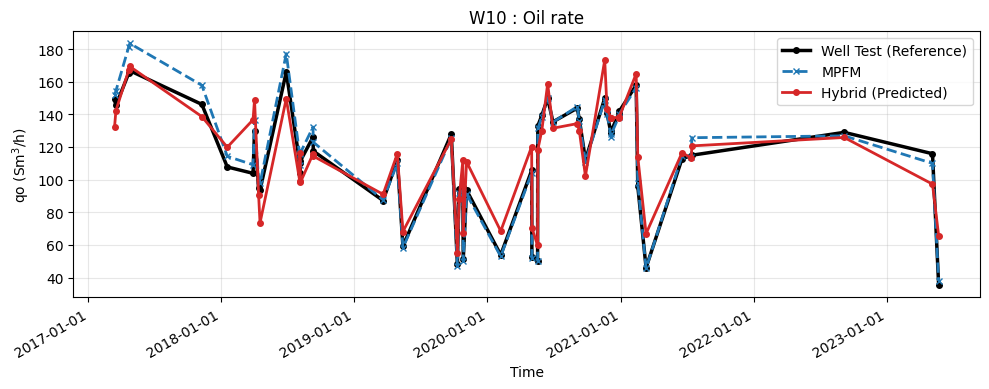

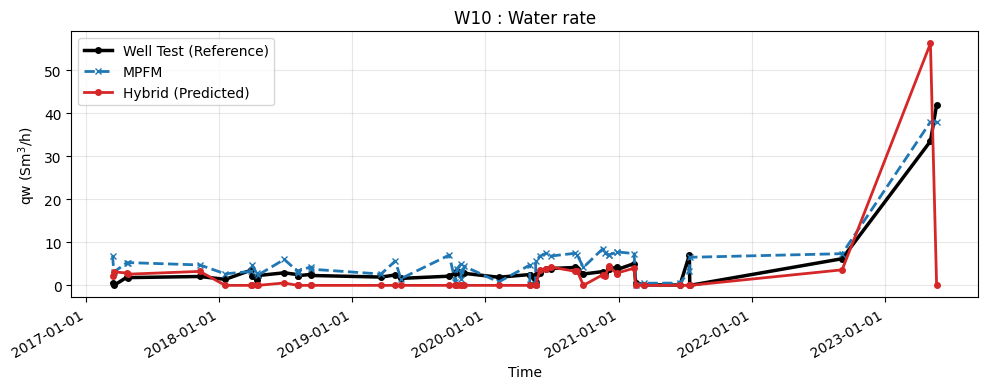

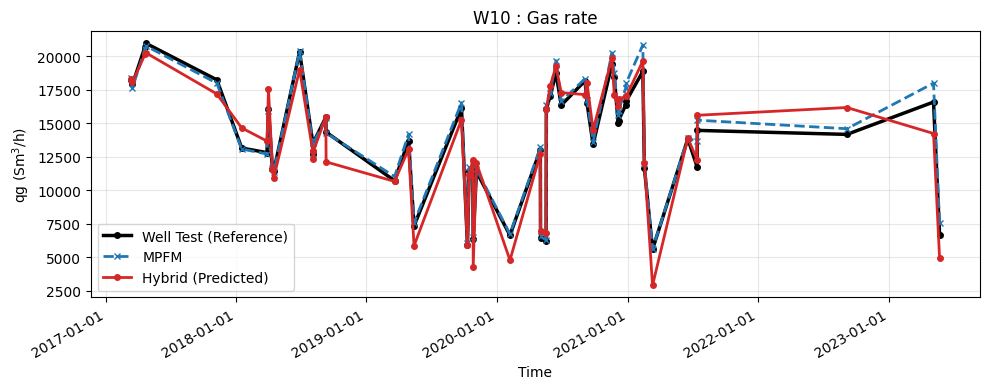

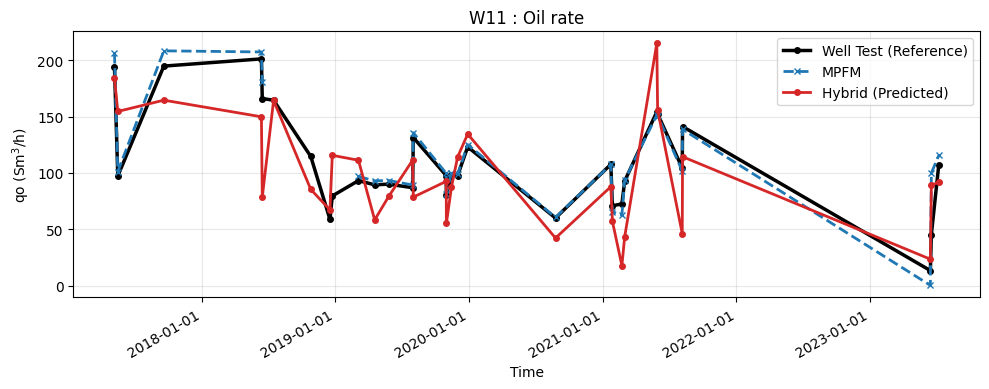

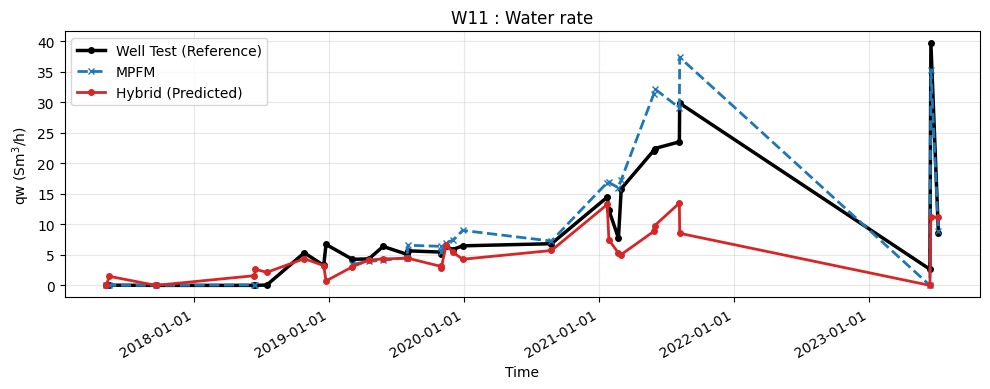

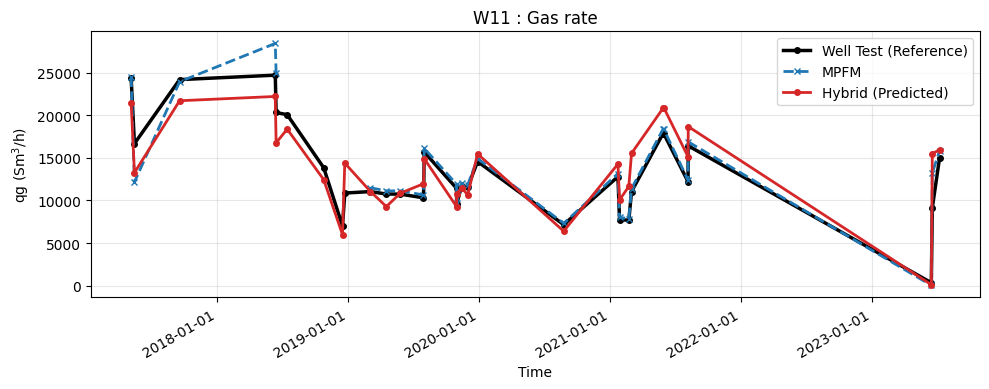

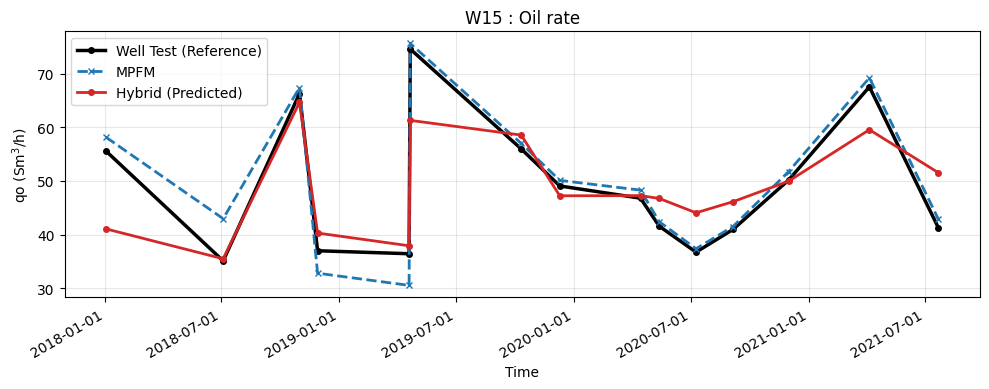

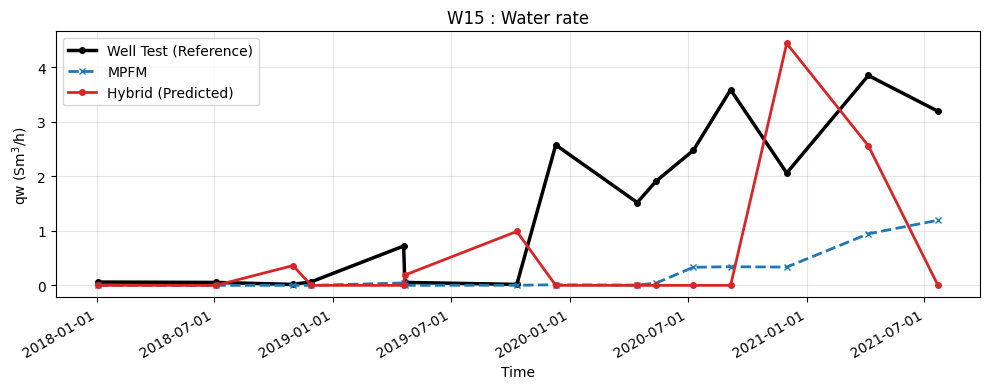

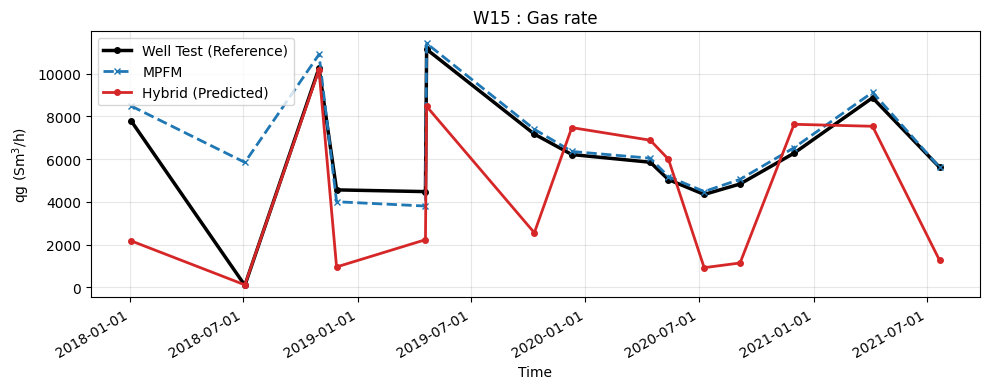

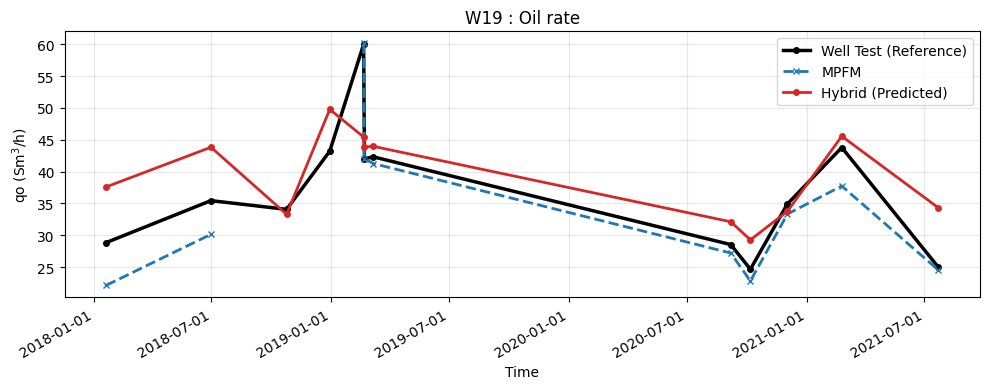

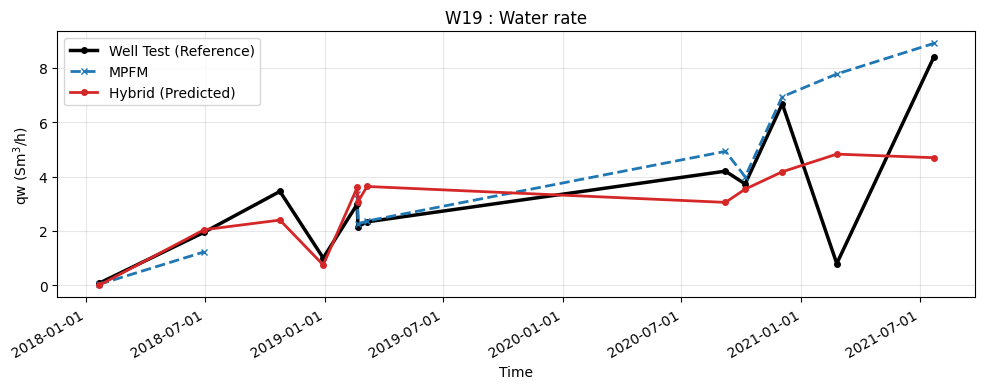

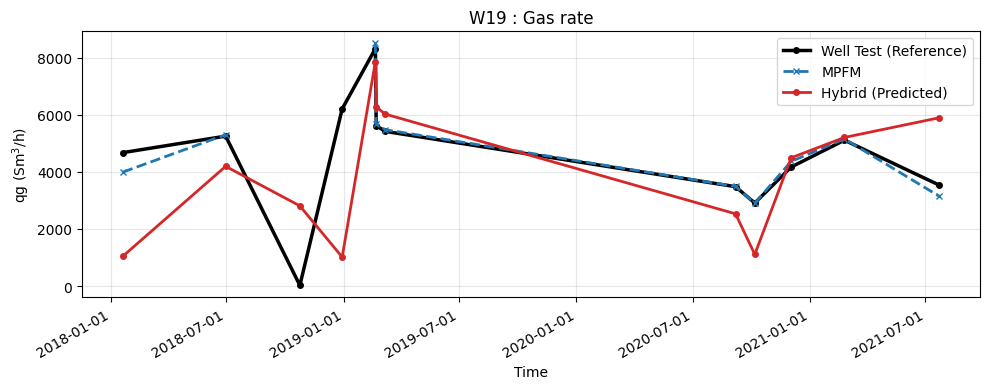

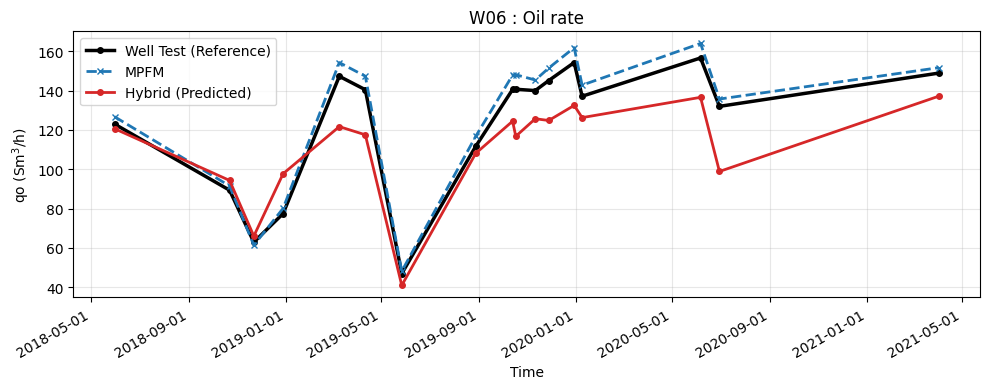

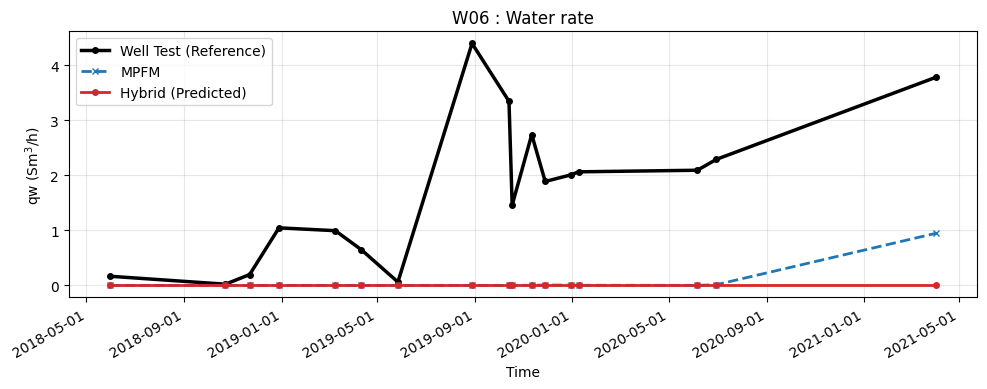

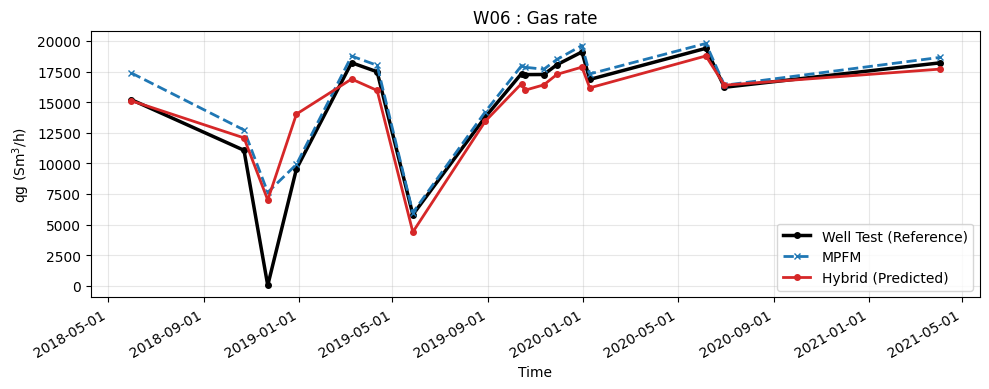

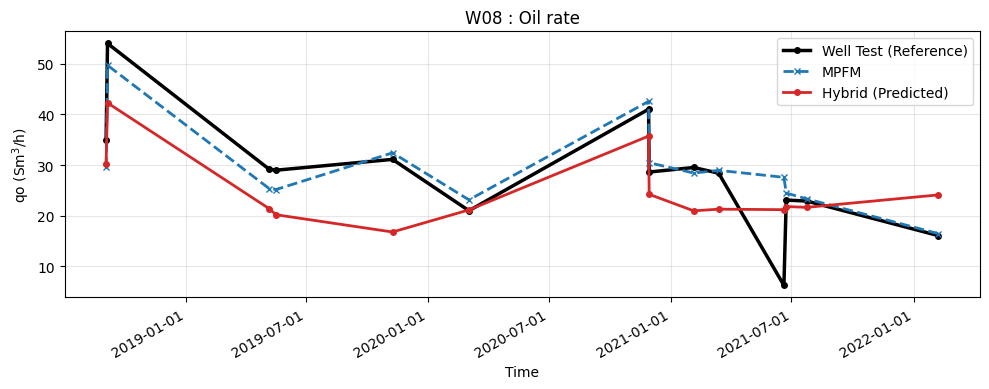

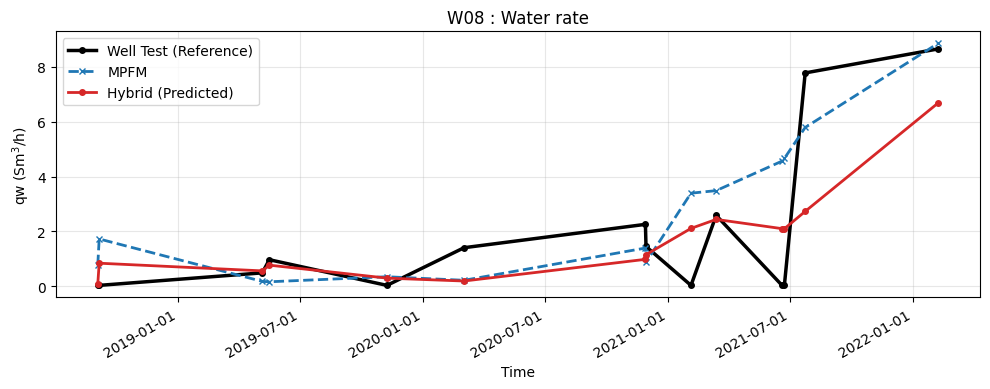

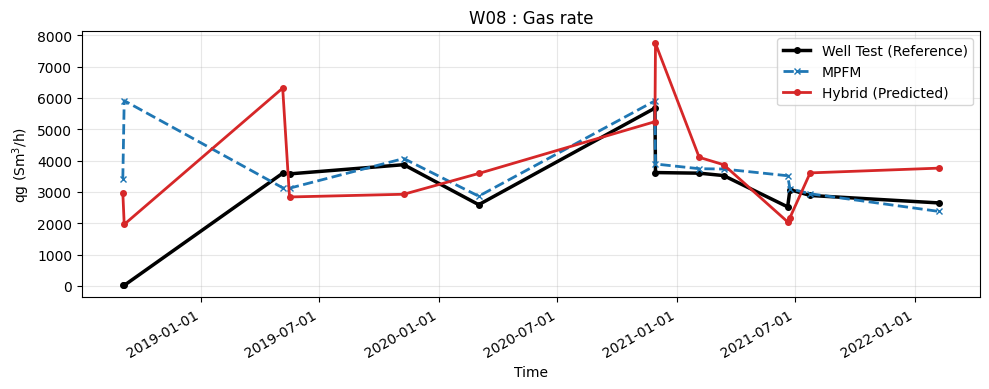

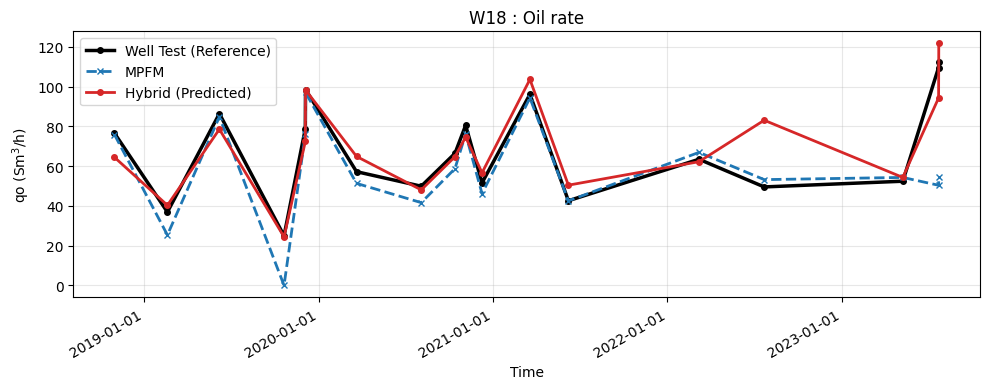

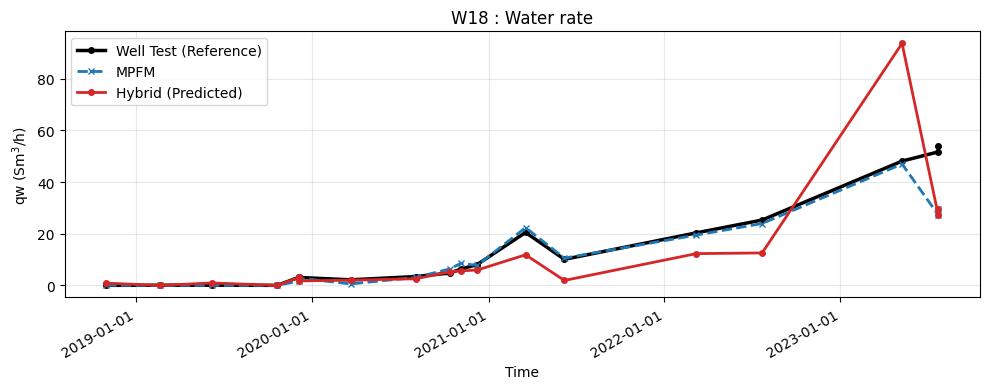

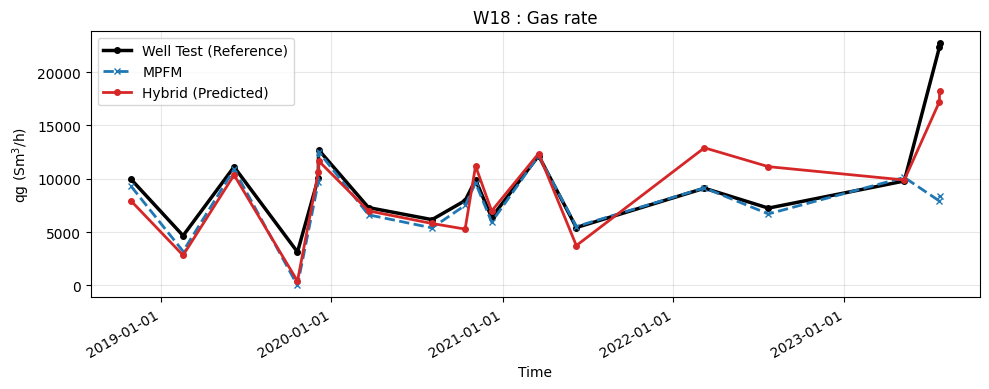

In [21]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [22]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=427, Val=107, Calibration=22, Test=199


In [23]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.6586


In [24]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

In [25]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.26548700719372686,
   'mae': 16.18304362961261,
   'rmse': 26.975063800103253,
   'mape (%)': 18.02194868018705,
   'mpe (%)': 10.518729664681981},
  'qw': {'r2': 0.28531957046883805,
   'mae': 3.0976646577350295,
   'rmse': 8.98547809318224,
   'mape (%)': 401161.6236381306,
   'mpe (%)': 401130.8714775226},
  'qg': {'r2': 0.45418586242206016,
   'mae': 2142.5120183207546,
   'rmse': 2907.0256451210435,
   'mape (%)': 131.1755176082301,
   'mpe (%)': 109.7590843421977},
  'wgr': {'r2': 0.1299915073607435,
   'mae': 0.0002781765326184983,
   'rmse': 0.0008608069452352656,
   'mape (%)': 481366.3544571637,
   'mpe (%)': 481338.4565460407},
  'gor': {'r2': -3.312810800984334,
   'mae': 18.879067156866636,
   'rmse': 27.84151134236685,
   'mape (%)': 95.85795866960075,
   'mpe (%)': 69.04223666355352}}}

In [26]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.44587512566938725,
   'mae': 17.312202923667783,
   'rmse': 23.429691066412836,
   'mape (%)': 14.913845050949625,
   'mpe (%)': -0.7952772191207457},
  'qw': {'r2': 0.4270151260435626,
   'mae': 3.1348000395588396,
   'rmse': 8.045570106419442,
   'mape (%)': 163669.12484519643,
   'mpe (%)': 163566.6562953676},
  'qg': {'r2': 0.6372324894572559,
   'mae': 1729.5641814679186,
   'rmse': 2369.958084919081,
   'mape (%)': 19.225529524654736,
   'mpe (%)': -4.720101249207953},
  'wgr': {'r2': 0.26262573386007815,
   'mae': 0.0002679508559019143,
   'rmse': 0.0007924794419371155,
   'mape (%)': 170687.462819127,
   'mpe (%)': 170585.17099263205},
  'gor': {'r2': -6.855871689999028,
   'mae': 25.497084111749807,
   'rmse': 37.575934854682636,
   'mape (%)': 24.658430249110943,
   'mpe (%)': -0.5059171983918014}}}

In [27]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9565222889214801,
   'mae': 3.9261103330409415,
   'rmse': 6.588661986850613,
   'mape (%)': 3.2842721062504117,
   'mpe (%)': 1.017492670440248},
  'qw': {'r2': 0.9222663219224193,
   'mae': 2.5702468257067457,
   'rmse': 2.976339694086438,
   'mape (%)': 380099.86238804884,
   'mpe (%)': 380088.74460561626},
  'qg': {'r2': 0.9451536126676259,
   'mae': 487.42740540954765,
   'rmse': 924.9801847612251,
   'mape (%)': 279.8037969307991,
   'mpe (%)': 278.9565382066985},
  'wgr': {'r2': 0.944798051632876,
   'mae': 0.00017618754859686345,
   'rmse': 0.0002178179736012386,
   'mape (%)': 374886.69676267885,
   'mpe (%)': 374875.50218310923},
  'gor': {'r2': 0.16072626557727687,
   'mae': 7.292965325969587,
   'rmse': 12.34296159923416,
   'mape (%)': 284.90575824010756,
   'mpe (%)': 281.1504482077674}}}

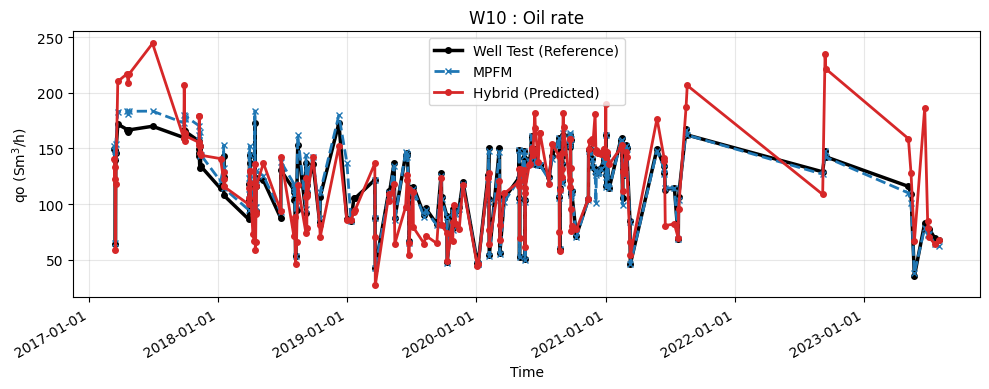

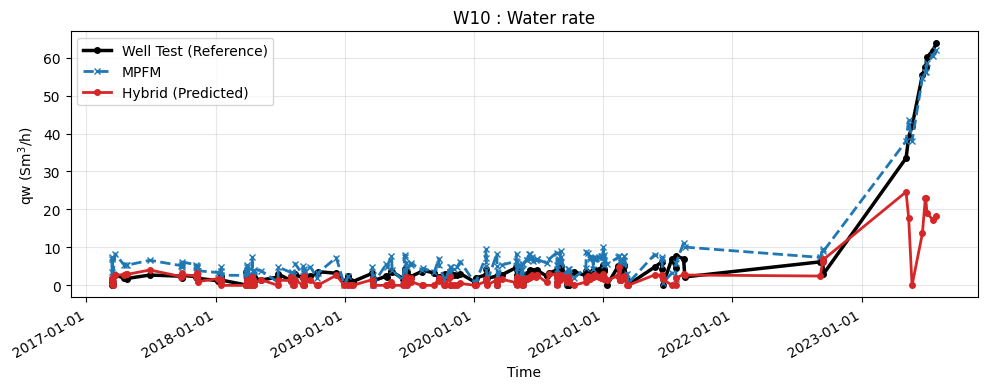

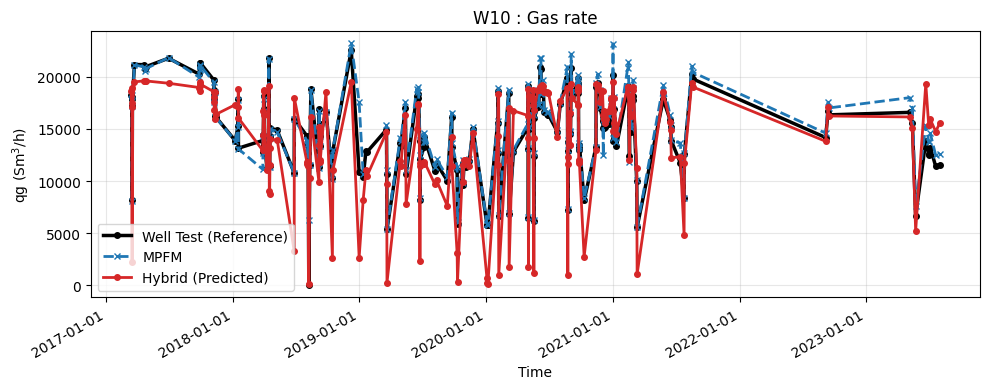

In [28]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [29]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [30]:
# df_resampled.index

In [31]:
# df_resampled.columns

In [32]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [33]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [34]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [35]:
# summarize_null(df_generated)